# Integrating surrogate gradients along closed path

Minimal example network
![setup.png](setup.png)

In [1]:
import jax.numpy as jnp
import jax
from jax import jit, vmap
from functools import partial

import numpy as np
from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
# Define colors

from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
silver = [230 / 255, 230 / 255, 230 / 255]  # RGB values for silver
dark_gray = [30 / 255, 30 / 255, 30 / 255]  # RGB values for dark gray

# Create a list of colors with a smooth transition from silver to dark gray
colors = [np.linspace(silver[i], dark_gray[i], 256) for i in range(3)]
colors = np.array(colors).T

# Create the custom colormap
gray_cmap = LinearSegmentedColormap.from_list("silver_to_dark_gray", colors, N=256)

yellow = "#EBB400"

## Define functions


In [3]:
# activation function and its gradient


@jit
def sigmoid(x, beta=1):
    return 1 / (1 + jnp.exp(-beta * x))


@jit
def grad_sigmoid(x, beta=1):
    return (beta * jnp.exp(-beta * x)) / ((jnp.exp(-beta * x) + 1) ** 2)

In [4]:
# Get network outputs


@partial(jit, static_argnums=(6))
def net_get_y_value(w_, x, a, b, d1, d2, beta):
    """Get one single value of network output for a specific set of parameter

    Args:
        w (array): network weigths (shape=(5,))
        x (float): input
        a (float): current step along direction d1
        b (float): current step along direction d2
        d1 (array): shape of the weigths, parameter direction for change
        d2 (array): shape of the weights, parameter direction for change
        beta (int): steepness of the sigmoid activation

    Returns:
        array: network outputs along shifting d1 and d2
    """

    w = w_[0] + d1[0] * a + d2[0] * b
    v1 = w_[1] + d1[1] * a + d2[1] * b
    v2 = w_[2] + d1[2] * a + d2[2] * b
    u1 = w_[3] + d1[3] * a + d2[3] * b
    u2 = w_[4] + d1[4] * a + d2[4] * b

    g = sigmoid(w * x, beta)
    h1 = sigmoid(v1 * g, beta)
    h2 = sigmoid(v2 * g, beta)
    y = sigmoid(u1 * h1 + u2 * h2, beta)

    return y

In [5]:
net_get_y_value_over_d1 = vmap(
    net_get_y_value, in_axes=(None, None, 0, None, None, None, None), out_axes=0
)
net_get_y_value_over_d2 = vmap(
    net_get_y_value_over_d1, in_axes=(None, None, None, 0, None, None, None), out_axes=0
)


def net(w, x, a, b, d1, d2, beta):
    """Get output values of the networks while shifting parameters along directions d1 and d2 with steps a and b, using beta

    Args:
        w (array): network weigths (shape=(5,))
        x (float): input
        a (array): steps along direction d1
        b (array): steps along direction d2
        d1 (array): shape of the weigths, parameter direction for change
        d2 (array): shape of the weights, parameter direction for change
        beta (int): steepness of the sigmoid activation

    Returns:
        array: network outputs along shifting d1 and d2
    """
    return net_get_y_value_over_d2(w, x, a, b, d1, d2, beta)

In [6]:
# compute network gradient


@jit
def grad_value(w, v1, v2, u1, u2, x, beta, beta_sg):
    """Compute the gradient for a specific set of weights"""
    g = sigmoid(w * x, beta)
    g_sg = grad_sigmoid(w * x, beta_sg)

    h1 = sigmoid(v1 * g, beta)
    h1_sg = grad_sigmoid(v1 * g, beta_sg)
    h2 = sigmoid(v2 * g, beta)
    h2_sg = grad_sigmoid(v2 * g, beta_sg)

    y = sigmoid(u1 * h1 + u2 * h2, beta)
    y_sg = grad_sigmoid(u1 * h1 + u2 * h2, beta_sg)

    dydu1 = h1 * y_sg
    dydu2 = h2 * y_sg

    dydh1 = u1 * y_sg
    dydh2 = u2 * y_sg

    dh1dv1 = g * h1_sg
    dh2dv2 = g * h2_sg

    dh1dg = v1 * h1_sg
    dh2dg = v2 * h2_sg

    dgdw = x * g_sg

    return jnp.array(
        [
            (dydh1 * dh1dg + dydh2 * dh2dg) * dgdw,
            dydh1 * dh1dv1,
            dydh2 * dh2dv2,
            dydu1,
            dydu2,
        ]
    )

In [7]:
def net_get_grad_value(w_, x, a, b, d1, d2, beta, beta_sg):
    w = w_[0] + d1[0] * a + d2[0] * b
    v1 = w_[1] + d1[1] * a + d2[1] * b
    v2 = w_[2] + d1[2] * a + d2[2] * b
    u1 = w_[3] + d1[3] * a + d2[3] * b
    u2 = w_[4] + d1[4] * a + d2[4] * b

    return grad_value(w, v1, v2, u1, u2, x, beta, beta_sg)


net_get_grad_value_over_d1 = vmap(
    net_get_grad_value,
    in_axes=(None, None, 0, None, None, None, None, None),
    out_axes=0,
)
net_get_grad_value_over_d2 = vmap(
    net_get_grad_value_over_d1,
    in_axes=(None, None, None, 0, None, None, None, None),
    out_axes=0,
)


def grad_net(w, x, a, b, d1, d2, beta, beta_sg):
    return net_get_grad_value_over_d2(w, x, a, b, d1, d2, beta, beta_sg)

In [8]:
# get integrated gradients


def get_int_grads(grads, d1, d2, ref_d1=0, ref_d2=0):
    grads_d1 = jnp.dot(grads, d1)
    grads_d2 = jnp.dot(grads, d2)

    # sum grads along direcion
    g1 = jnp.cumsum(grads_d1, axis=1) + ref_d1
    g2 = jnp.cumsum(grads_d2, axis=0) + ref_d2

    return g1, g2

In [9]:
def get_ig(ig1_dict, ig2_dict, beta_sg, lines):
    ig_l1 = jnp.array(ig1_dict[beta_sg][lines[0][:, 0], lines[0][:, 1]])

    ig_l2 = jnp.array(ig2_dict[beta_sg][lines[1][:, 0], lines[1][:, 1]])
    ig_l2 += ig_l1[-1].item() - ig_l2[0].item()

    ig_l3 = jnp.array(ig1_dict[beta_sg][lines[2][:, 0], lines[2][:, 1]])
    ig_l3 += ig_l2[-1].item() - ig_l3[0].item()

    ig_l4 = jnp.array(ig2_dict[beta_sg][lines[3][:, 0], lines[3][:, 1]])
    ig_l4 += ig_l3[-1].item() - ig_l4[0].item()

    ig = jnp.concatenate([ig_l1, ig_l2, ig_l3, ig_l4])

    return ig

In [10]:
# plotting


def contour(
    ax, x, y, z, levels=20, vmin=0, vmax=1, color="k", linewidths=0.5, cmap=gray_cmap
):
    im = ax.contourf(x, y, z, levels, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.contour(x, y, z, levels, colors=color, linewidths=linewidths)
    return im

In [11]:
def normalize(x):
    x = jnp.array(x)
    return (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

In [12]:
def generate_circle_coordinates(radius, num_points):
    x_coords = []
    y_coords = []
    for i in range(num_points):
        angle = 2 * jnp.pi * i / num_points
        x = radius * jnp.sin(angle)
        y = radius * jnp.cos(angle)
        x_coords.append(x)
        y_coords.append(y)
    x_coords.append(x_coords[0])
    y_coords.append(y_coords[0])
    return jnp.array(x_coords), jnp.array(y_coords)

## Define parameters


In [13]:
preamble = "Plots/"

In [14]:
inp = jnp.array(1)
# weights = jnp.array([0.05, 0.025, -0.1, 0.05, 0.05])
weights = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])

beta_sgs = [1, 5, 20]
beta = 10000

In [15]:
a_steps = jnp.linspace(-2, 2, 2000)
b_steps = jnp.linspace(-2, 2, 2000)

difference = {}
num_points = 1500
radius = 1.8

x_coords, y_coords = generate_circle_coordinates(radius, num_points)

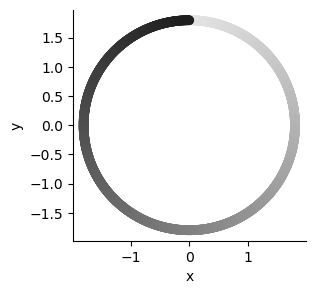

In [16]:
# plot circle coordinates
plt.figure(figsize=(3,3))
plt.scatter(
    x_coords,
    y_coords,
    c=range(len(y_coords)),
    cmap=gray_cmap,
)
plt.xlabel("x")
plt.ylabel("y")
sns.despine()

In [17]:
# chose two random orthogonal directions to walk a closed circle on the loss landscape
seed = 124

m = ortho_group.rvs(5, random_state=seed)
d1 = jnp.array(list(m[0]))
d2 = jnp.array(list(m[1]))

d1 = m[0]  
d2 = m[1]  

d1 = d1 / jnp.linalg.norm(d1) * 1
d2 = d2 / jnp.linalg.norm(d2) * 1

print("Dot product:", jnp.dot(d1, d2))
print("Norm:", jnp.linalg.norm(d1), jnp.linalg.norm(d2))
print("d1:", d1)
print("d2:", d2)

Dot product: -3.039809e-08
Norm: 1.0 1.0
d1: [ 0.09305991  0.5905991  -0.30914232  0.4299941  -0.60172135]
d2: [-0.14934348  0.25011492  0.26179737 -0.78792286 -0.47516188]


## Plot network output


  0%|          | 0/4 [00:00<?, ?it/s]

0 1


 25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

1 5


 50%|█████     | 2/4 [00:06<00:06,  3.05s/it]

2 20


 75%|███████▌  | 3/4 [00:08<00:02,  2.97s/it]

3 10000


100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


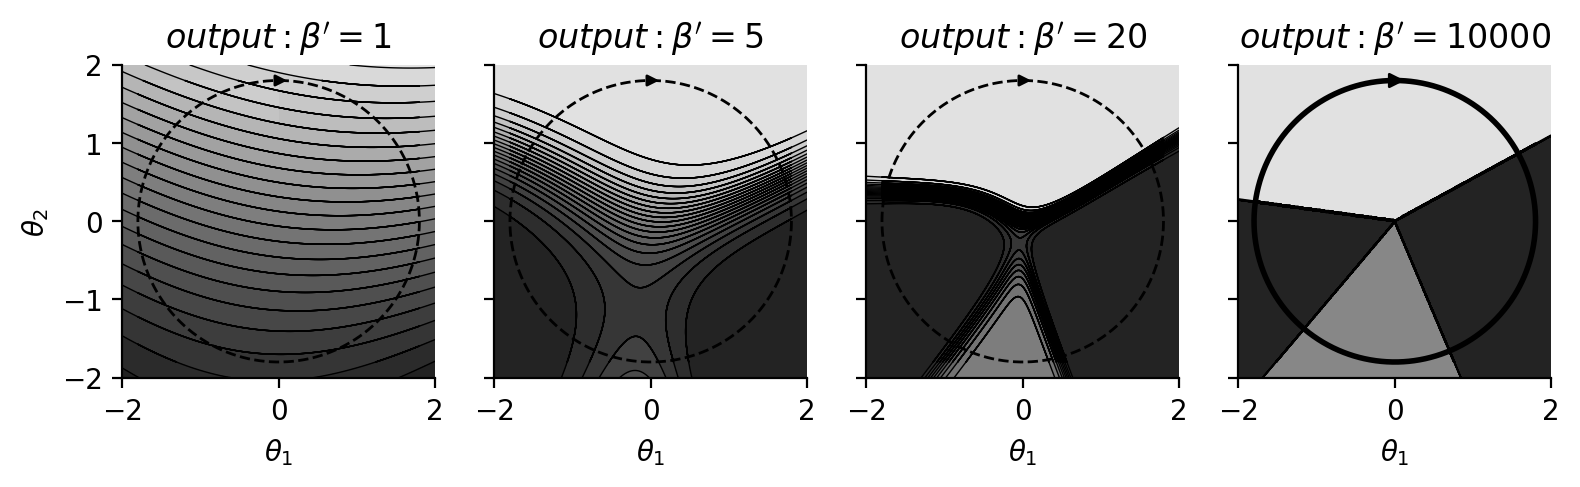

In [18]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs) + 1,
    figsize=(2 * len(beta_sgs) + 2, 3),
    dpi=200,
    sharex=True,
    sharey=True,
    subplot_kw={"adjustable": "box", "aspect": 1},
)

y_dict = {}
y_smooth = {}
y_smooth_circle = {}

for i, beta_sg in enumerate(tqdm(beta_sgs + [beta])):
    print(i, beta_sg)
    y_s = net(weights, inp, x_coords, y_coords, d1, d2, beta_sg)
    y_smooth[beta_sg] = y_s

    y_s_circle = net(weights, inp, a_steps, b_steps, d1, d2, beta_sg)
    y_smooth_circle[beta_sg] = y_s_circle

    contour(
        ax[i],
        a_steps,
        b_steps,
        y_smooth_circle[beta_sg],
        vmin=None,
        vmax=None,
        cmap=gray_cmap,
        color="k",
    )

    contour(
        ax[i],
        x_coords,
        y_coords,
        y_smooth[beta_sg],
        vmin=None,
        vmax=None,
        cmap=gray_cmap,
        color="k",
    )

    ax[i].set_title(r"$output: \beta' = {}$".format(beta_sg))
    ax[i].set_xlabel(r"$\theta_1$")

    if i < len(beta_sgs):
        ax[i].plot(x_coords, y_coords, color="black", ls="--", lw=1)
        ax[i].scatter(x_coords[0], y_coords[0], color="black", s=11, marker=">")
    else:
        ax[i].plot(x_coords, y_coords, color="black", lw=2)
        ax[i].scatter(x_coords[0], y_coords[0], color="black", s=20, marker=">")


ax[0].set_ylabel(r"$\theta_2$")

plt.tight_layout()
sns.despine()

plt.savefig(preamble + "_out.svg")
plt.show()

## Plot integrated gradients along circle

In [19]:
circle_out = {}
circle_out_smooth = {}
circle_grad = {}
circle_grad_smooth = {}

for i, beta_sg in enumerate(beta_sgs):
    circle_out[beta_sg] = []
    circle_out_smooth[beta_sg] = []
    circle_grad[beta_sg] = []
    circle_grad_smooth[beta_sg] = []

    for x, y in tqdm(zip(x_coords, y_coords), total=num_points):
        out = net(weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta)
        circle_out[beta_sg].append(out.item())

        out_s = net(weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta_sg)
        circle_out_smooth[beta_sg].append(out_s.item())

        grads = grad_net(
            weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta, beta_sg
        )
        circle_grad[beta_sg].append(grads[0, 0, :])

        grads_s = grad_net(
            weights, inp, jnp.array([x]), jnp.array([y]), d1, d2, beta_sg, beta_sg
        )
        circle_grad_smooth[beta_sg].append(grads_s[0, 0, :])

    circle_out[beta_sg] = jnp.array(circle_out[beta_sg])
    circle_out_smooth[beta_sg] = jnp.array(circle_out_smooth[beta_sg])
    circle_grad[beta_sg] = jnp.array(circle_grad[beta_sg])
    circle_grad_smooth[beta_sg] = jnp.array(circle_grad_smooth[beta_sg])

1501it [00:42, 35.26it/s]                          
1501it [00:41, 36.08it/s]                          
1501it [00:40, 37.05it/s]                          


In [20]:
circle_ig = {}
circle_ig_smooth = {}

for i, beta_sg in enumerate(beta_sgs):
    circle_ig[beta_sg] = []
    circle_ig_smooth[beta_sg] = []

    for j, (g, gs) in enumerate(zip(circle_grad[beta_sg], circle_grad_smooth[beta_sg])):
        weights_pre = weights + d1 * x_coords[j - 1] + d2 * y_coords[j - 1]
        weights_post = weights + d1 * x_coords[j + 1] + d2 * y_coords[j + 1]

        dir = weights_post - weights_pre
        dir /= jnp.linalg.norm(dir)

        ig = jnp.dot(dir, g)
        circle_ig[beta_sg].append(ig)

        ig_s = jnp.dot(dir, gs)
        circle_ig_smooth[beta_sg].append(ig_s)

    circle_ig[beta_sg] = jnp.array(circle_ig[beta_sg])
    circle_ig_smooth[beta_sg] = jnp.array(circle_ig_smooth[beta_sg])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


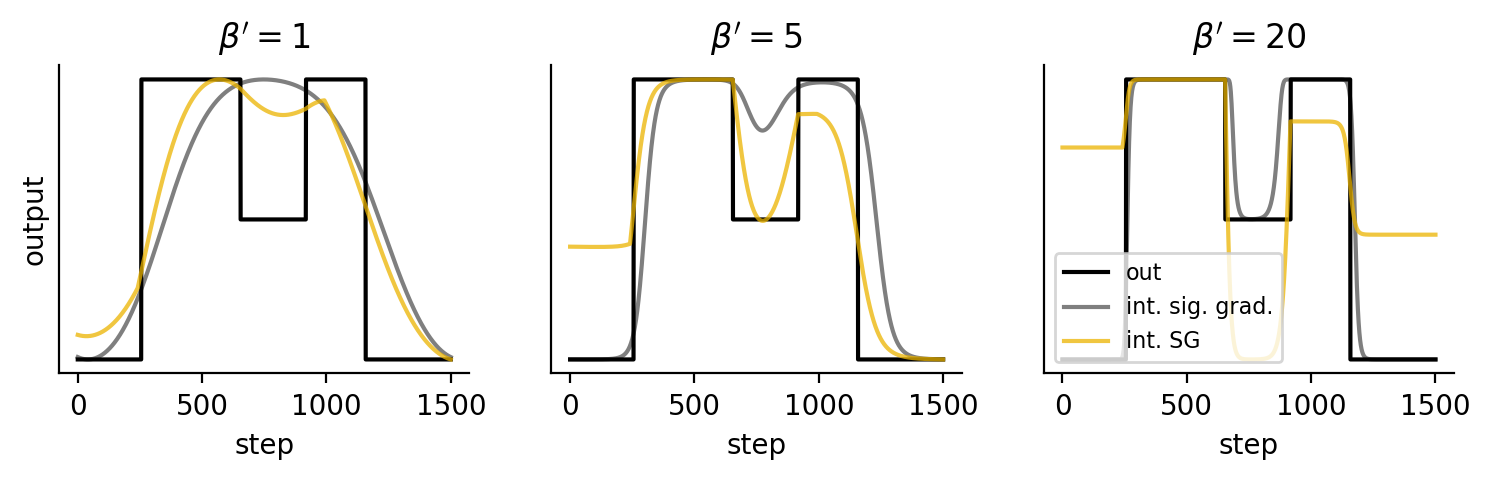

In [21]:
fig, ax = plt.subplots(
    1,
    len(beta_sgs),
    figsize=(3 * len(beta_sgs), 2),
    dpi=200,
    sharex=True,
    sharey=True,
)

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    # ax[i].hlines(0, len(circle_out_smooth[beta_sg]), 0, linestyle="--", color="silver")
    ax[i].plot(normalize(circle_out[beta_sg]), color="black", label="out")
    ax[i].plot(
        normalize(jnp.cumsum(circle_ig_smooth[beta_sg])),
        color="black",
        alpha=0.5,
        label="int. sig. grad.",
    )
    ax[i].plot(
        normalize(jnp.cumsum(circle_ig[beta_sg])),
        color=yellow,
        alpha=0.75,
        label="int. SG",
    )

    ax[i].set_title(r"$\beta'= {}$".format(beta_sg))

    ax[i].set_xlabel("step")

ax[0].set_ylabel("output")
ax[0].set_yticks([])

ax[-1].legend(loc="lower left", fontsize=8, )
sns.despine()

#### Plot integrated gradients along circle for different $\beta_{SG}$-values on same plot and scale all integrated SGs the same

100%|██████████| 3/3 [00:00<00:00, 309.16it/s]


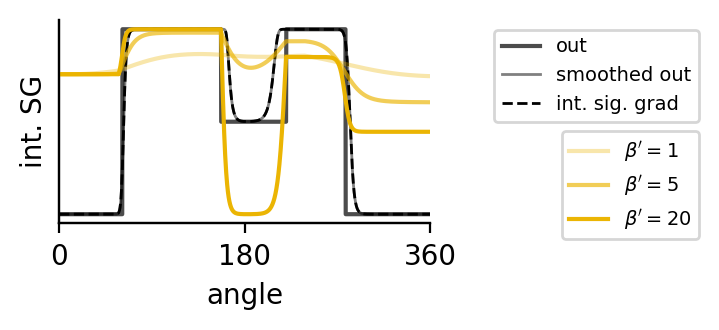

In [22]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(5.5, 1.75),
    dpi=200,
    sharex=True,
    sharey=True,
)

# plot on second y-axis
ax2 = ax.twinx()
ax.plot(circle_out[beta_sg], color="black", alpha=0.7, label="out", zorder=-10)
ax.plot(
    normalize(jnp.cumsum(circle_ig_smooth[beta_sg]) - 1),
    color="gray",
    lw=1,
    label="smoothed out",
    zorder=-11,
)
ax.plot(
    normalize(jnp.cumsum(circle_ig_smooth[beta_sg]) - 1),
    color="black",
    ls="--",
    lw=1,
    label="int. sig. grad",
    zorder=-10,
)
ax2.set_yticks([])

for i, beta_sg in enumerate(tqdm(beta_sgs)):
    # ax[i].hlines(0, len(circle_out_smooth[beta_sg]), 0, linestyle="--", color="silver")
    ax2.plot(
        jnp.cumsum(circle_ig[beta_sg]) - 1,
        color=yellow,
        alpha=0.33 * (i + 1),
        label=r"$\beta'= {}$".format(beta_sg),
    )

    ax.set_xlabel("angle")


ax.set_ylabel("int. SG")
ax.set_yticks([])

ax.legend(fontsize=7, loc="upper right", ncol=1, bbox_to_anchor=(1.75, 1.0))
ax2.legend(fontsize=7, loc="upper right", ncol=1, bbox_to_anchor=(1.75, 0.5))
sns.despine()
ax.set_xlim(0, num_points)
ax2.set_xlim(0, num_points)
ax.set_xticks([0, num_points / 2, num_points], [0, 180, 360])

plt.tight_layout()

plt.savefig(preamble + "_all_ig_circle.svg")